## Loading

In [166]:
import torch
import torch.nn as nn
import torch.optim as optim
import datasets
import pandas as pd
import seaborn as sns
from bertviz import model_view, head_view


from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from transformers import (
    ElectraTokenizerFast,
    ElectraForSequenceClassification,
    ElectraConfig,
)

from helpers import prepare_dataset_nli

NUM_PREPROCESSING_WORKERS = 2
pretrained_model = "google/electra-small-discriminator"
train_path = './trains/'
eval_path= './evals/'
dataset_name = './snli_classic/'
labels_map = {0: 'entailment', 1: "neutral", 2:"contradiction"}

# dataset_name = 'snli_classic/'

# dataset_name = './snli_hyponly/'


## Device check

In [167]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

There are 8 GPU(s) available.
Device name: Tesla K80


## Model

In [168]:
# Train Params
lr = 2e-5
num_epochs = 1
batch_size = 36*torch.cuda.device_count()
# Load the model
config = ElectraConfig.from_pretrained(pretrained_model)
config.gradient_checkpointing = False
config.use_cache = True
# config.problem_type = "multi_label_classification"
config.num_labels = 3

model = ElectraForSequenceClassification.from_pretrained(
    "google/electra-small-discriminator",
    config=config
)

# Move model to device
# Create the Optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5 ,6 ,7])
model.to(device)


Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

DataParallel(
  (module): ElectraForSequenceClassification(
    (electra): ElectraModel(
      (embeddings): ElectraEmbeddings(
        (word_embeddings): Embedding(30522, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
      (encoder): ElectraEncoder(
        (layer): ModuleList(
          (0): ElectraLayer(
            (attention): ElectraAttention(
              (self): ElectraSelfAttention(
                (query): Linear(in_features=256, out_features=256, bias=True)
                (key): Linear(in_features=256, out_features=256, bias=True)
                (value): Linear(in_features=256, out_features=256, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
          

## Dataset loading and preprocessing

In [174]:
dataset = datasets.load_dataset('snli')
dataset = dataset.filter(lambda ex: ex['label'] != -1)

if dataset_name == './snli_hyponly/':
    df = dataset['train'].to_pandas()
    df['premise'] = ' '
    dataset = datasets.DatasetDict({'train': datasets.Dataset.from_pandas(df)}) 

tokenizer = ElectraTokenizerFast.from_pretrained(pretrained_model)
prepare_train_dataset = prepare_eval_dataset = lambda exs: prepare_dataset_nli(exs, tokenizer, 128)

train_dataset = dataset['train']
train_dataset_featurized = train_dataset.map(
    prepare_train_dataset,
    batched=True,
    num_proc=NUM_PREPROCESSING_WORKERS,
    remove_columns=train_dataset.column_names
)

# config = ElectraConfig.from_pretrained(dataset_name + 'model')
# model = ElectraForSequenceClassification.from_pretrained(dataset_name + 'model', config=config)
# tokenizer = ElectraTokenizerFast.from_pretrained(dataset_name + 'model')
# model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5 ,6 ,7])
# model.to(device)

train_loader = DataLoader(train_dataset_featurized, batch_size=batch_size, shuffle=False, pin_memory=True)

Reusing dataset snli (/home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)
Loading cached processed dataset at /home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-4eacbddb81939caf.arrow
Loading cached processed dataset at /home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-ab24f4c6f0ce7e93.arrow
Loading cached processed dataset at /home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-a1c734a8e7f96896.arrow
Loading cached processed dataset at /home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-5ce4ee926f0e714a.arrow
Loading cached processed dataset at /home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f

## Train

In [175]:
model.train()

global_step = 0
probabilities = {}
# You can choose to do your own loss calculation if you'd like, but I'm keeping things simple here
loss = None

for epoch in range(num_epochs):
    pragati = tqdm(train_loader, desc=f'Epoch {epoch}', leave=False)

    for n, batch in enumerate(pragati):
    
        model.zero_grad()
        labels = batch.pop('label')
        labels = labels.to(device)
        for k in batch:
            batch[k] = torch.stack(batch[k], dim=1).to(device)
        model_output = model(**batch, labels=labels)
        loss = model_output.loss
        loss.sum().backward()
        optimizer.step()
        global_step += 1

        if n % 20 == 0:
            pragati.set_description(f'Epoch: {epoch} | Step: {global_step} | Loss: {loss.mean():.2f}')

    model.eval()
    probabilities[epoch] = []
    acc = []
    for batch in tqdm(train_loader):
        model.zero_grad()

        labels = batch.pop('label')
        labels = labels.to(device)
        for k in batch:
            batch[k] = torch.stack(batch[k], dim=1).to(device)
        model_output = model(**batch, labels=labels)

        probs = []
        as_probs = torch.functional.F.softmax(model_output.logits, dim=1)
        for out, label in zip(as_probs, labels):
            probs.append(out[label].item())
        probabilities[epoch] += probs

        acc.append((model_output.logits.argmax(1) == labels).cpu().numpy())

    acc = np.concatenate(acc)
    print(f'Epoch {epoch} | Accuracy: {acc.sum() / len(acc)} | Loss : {loss.mean():.2f}')


print(f'Completed Training at Epoch {epoch} | Global Step: {global_step} | Loss : {loss.mean():.2f}')

tokenizer.save_pretrained(dataset_name + 'model')
model.module.save_pretrained(dataset_name + 'model')
config.save_pretrained(dataset_name + 'model')

Epoch 0:   0%|          | 0/1908 [00:00<?, ?it/s]

In [165]:
np.concatenate([a,b]).shape

(576,)

In [161]:
a = (model_output.logits.argmax(1) == labels).cpu().numpy()
b = (model_output.logits.argmax(1) == labels).cpu().numpy()

## Evaluation

In [67]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
dataset = datasets.load_dataset('snli')
dataset = dataset.filter(lambda ex: ex['label'] != -1)


df_1 = dataset['validation'].to_pandas()
df_2 = dataset['test'].to_pandas()
df = pd.concat([df_1, df_2], axis=0).reset_index(drop=True)

if dataset_name == './snli_hyponly/':
    df['premise'] = ' '

dataset = datasets.DatasetDict({'validation': datasets.Dataset.from_pandas(df)}) 




# dataset = datasets.load_dataset('snli')
# dataset = dataset.filter(lambda ex: ex['label'] != -1)

batch_size = 1 #36*torch.cuda.device_count()
# config = ElectraConfig.from_pretrained(pretrained_model)
# config.gradient_checkpointing = False
# config.use_cache = True
# # config.problem_type = "multi_label_classification"
# config.num_labels = 3

# config = ElectraConfig.from_pretrained(dataset_name + 'model')
model = ElectraForSequenceClassification.from_pretrained(dataset_name + 'model')#,# config=config)
tokenizer = ElectraTokenizerFast.from_pretrained(dataset_name + 'model')

Reusing dataset snli (/home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)
Loading cached processed dataset at /home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-4eacbddb81939caf.arrow
Loading cached processed dataset at /home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-ab24f4c6f0ce7e93.arrow
Loading cached processed dataset at /home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-a1c734a8e7f96896.arrow


In [68]:
prepare_train_dataset = prepare_eval_dataset = lambda exs: prepare_dataset_nli(exs, tokenizer, 128)

eval_dataset = dataset['validation']
eval_dataset_featurized = eval_dataset.map(
    prepare_eval_dataset,
    batched=False,
    num_proc=NUM_PREPROCESSING_WORKERS,
    remove_columns=['label'] #eval_dataset.column_names
)
# eval_loader = DataLoader(eval_dataset_featurized, batch_size=batch_size, shuffle=True, pin_memory=True)

In [69]:
# loss = nn.CrossEntropyLoss()
model_keys = ['input_ids', 'token_type_ids', 'attention_mask']
model.eval()
model.to(device)
eval_samples = []
attentions = []
for n, sample in tqdm(enumerate(eval_dataset_featurized), total=len(eval_dataset_featurized)):

    # Change labels depending on whether you're doing NER/Parsing (token classification)
    # or sentiment classification (sequence classification)
    # ELECTRA Page linked here: https://huggingface.co/transformers/model_doc/electra.html
    labels = torch.LongTensor([sample['labels']]).to(device)
    model_inputs = {k:torch.LongTensor(v).to(device).reshape(1,-1) for k,v in sample.items() if k in model_keys}
    model_output = model(**model_inputs, labels=labels, output_attentions = True)
    sample['loss'] = model_output.loss.item()
    sample['predicted_label'] = model_output.logits[0].argmax().item()
    for i, logit in enumerate(model_output.logits[0]):
        sample[f'logit_{i}'] = logit.item()

    # attentions.append([att.detach() for att in  model_output.attentions])
    
    eval_samples.append(sample)


  0%|          | 0/19666 [00:00<?, ?it/s]

In [70]:
# eval_df = pd.DataFrame(eval_samples)
# eval_df.to_parquet(dataset_name + 'eval/eval_df.parquet')

In [96]:
eval_df_orig = pd.read_parquet('./snli_classic/' + 'eval/eval_df.parquet') 
eval_df_orig['correct'] = eval_df_orig.labels == eval_df_orig.predicted_label


In [98]:
correct = eval_df_orig.loc[eval_df['correct']]
incorrect = eval_df_orig.loc[~eval_df['correct']]

In [100]:
correct.correct.sum() / len(correct)

0.9510587886865097

In [101]:
incorrect.correct.sum() / len(incorrect)

0.7366883116883117

In [71]:
eval_df = pd.read_parquet(dataset_name + 'eval/eval_df.parquet')
eval_df['correct'] = eval_df.labels == eval_df.predicted_label
errors = eval_df.loc[eval_df.labels != eval_df.predicted_label].sort_values('loss', ascending=False)

In [93]:
eval_df.correct.sum() / len(eval_df)

0.6867690430184074

In [11]:
errors.groupby('labels').count()

,premise,hypothesis,input_ids,token_type_ids,attention_mask,loss,predicted_label,logit_0,logit_1,logit_2
labels,,,,,,,,,,
0,658,658,658,658,658,658,658,658,658,658
1,816,816,816,816,816,816,816,816,816,816
2,809,809,809,809,809,809,809,809,809,809


### PMI Calculation

In [79]:
dataset = datasets.load_dataset('snli')
dataset = dataset.filter(lambda ex: ex['label'] != -1)
tokenizer = ElectraTokenizerFast.from_pretrained(pretrained_model)

max_seq_length = 128
examples = []
labels = []
for example in tqdm(dataset['train']):
    tokenized_example = tokenizer(
        example['premise'],
        example['hypothesis'],
        truncation=True,
        max_length=max_seq_length,
        padding='max_length'
    )
    labels.append(example['label'])
    examples.append(tokenized_example['input_ids'])

Reusing dataset snli (/home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)
Loading cached processed dataset at /home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-4eacbddb81939caf.arrow
Loading cached processed dataset at /home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-ab24f4c6f0ce7e93.arrow
Loading cached processed dataset at /home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-a1c734a8e7f96896.arrow


  0%|          | 0/549367 [00:00<?, ?it/s]

In [80]:
import numpy as np
examples = np.array(examples)
labels = np.array(labels)

denominator = np.zeros(tokenizer.vocab_size)
unique, counts = np.unique(examples, return_counts=True)
total_tokens = counts[1:].sum()
probabilities = counts[1:] / total_tokens
for tok_id, prob in zip(unique[1:], probabilities):
    denominator[tok_id] = prob

classes = {0: None, 1: None, 2: None}
for cl in classes:
    subset = examples[labels == cl]
    pmi = np.zeros(tokenizer.vocab_size)
    unique, counts = np.unique(subset, return_counts=True)
    probabilities = counts[1:] / counts[1:].sum()
    for tok_id, prob in zip(unique[1:], probabilities):
        pmi[tok_id] = prob
    zeroes = probabilities == 0
    classes[cl] = pmi / denominator
    # classes[cl] = (pmi + 100) / (denominator + unique.shape[0] * 100)
    # classes[cl][zeroes] = 0


/tmp/ipykernel_18873/4202481382.py:21: RuntimeWarning: invalid value encountered in true_divide
  classes[cl] = pmi / denominator


In [81]:
pmi_df = pd.DataFrame(classes)
pmi_df['counts'] = (total_tokens * denominator).astype(int) #drop unused tokens
pmi_df = pmi_df.loc[pmi_df.iloc[:, :3].sum(1) != 0]
l_map = labels_map.copy()
l_map.update({'counts':'counts'})
pmi_df.columns = pmi_df.columns.map(l_map)
pmi_df['std'] = pmi_df.iloc[:,:3].std(1)
pmi_df['avg'] = pmi_df.iloc[:,:3].mean(1)
pmi_df['token'] = tokenizer.convert_ids_to_tokens(pmi_df.index)

pmi_df

,entailment,neutral,contradiction,counts,std,avg,token
101,1.081664,0.927519,1.002377,549367,0.077083,1.003853,[CLS]
102,1.081664,0.927519,1.002377,1098734,0.077083,1.003853,[SEP]
999,0.385690,1.062101,1.503035,168,0.562793,0.983608,!
1000,0.626280,1.350822,0.968498,807,0.362456,0.981867,""""
1001,1.117171,0.961384,0.932918,28,0.099187,1.003824,#
...,...,...,...,...,...,...,...
29594,0.341031,0.880425,1.740356,19,0.705755,0.987271,stalks
29599,0.000000,0.000000,3.006070,1,1.735555,1.002023,##rrard
29600,0.000000,2.788014,0.000000,2,1.609661,0.929338,collarbone
29602,0.000000,1.858676,1.002023,3,0.930285,0.953566,##wil


In [82]:
pmi_df.to_parquet('pmi_hyponly.parquet')

In [91]:
sel_pmi = pmi_df.loc[pmi_df_full.counts.between(100, 50000) & (pmi_df.token.str.len() > 1)]
e_ = sel_pmi.sort_values('entailment',ascending=False).head(15)
n_ = sel_pmi.sort_values('neutral',ascending=False).head(15)
c_ = sel_pmi.sort_values('contradiction',ascending=False).head(15)
top_pmi = pd.concat([e_.token, n_.token, c_.token]).drop_duplicates()

# ' '.join(c_.token.head(6).to_list())
eval_df['top_pmi'] = eval_df.input_ids.apply(lambda x: any([ e in top_pmi.index for e in x]))
sel = eval_df.loc[eval_df.top_pmi]
sel.correct.sum() / len(sel)

0.8981042654028436

In [92]:
sel_pmi

,entailment,neutral,contradiction,counts,std,avg,token
2001,0.781999,1.152442,1.037910,5361,0.189665,0.990783,was
2002,0.493108,1.733646,0.679298,5151,0.668985,0.968684,he
2004,0.703851,1.389784,0.854515,5611,0.360489,0.982717,as
2005,0.411632,1.941375,0.530920,25060,0.850855,0.961309,for
2008,0.765565,1.556943,0.617020,3157,0.505272,0.979843,that
...,...,...,...,...,...,...,...
29500,0.305641,1.367705,1.247803,52,0.581668,0.973716,starbucks
29508,1.058757,1.275562,0.648368,153,0.318537,0.994229,inspecting
29515,0.342613,0.786230,1.840451,539,0.769382,0.989765,chases
29549,0.935199,1.005984,1.053674,97,0.059612,0.998286,binoculars


0.8870836718115354

In [ ]:
#0.887 - subset with par small

In [29]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pmi_df = pd.DataFrame(classes)


# pmi_df = pmi_df.loc[pmi_df.sum(1) != 0] #drop unused tokens
pmi_df.columns = pmi_df.columns.map(labels_map)
pmi_df['counts'] = (total_tokens * denominator).astype(int)
pmi_df = np.log(pmi_df).replace(-np.inf, 0)

pmi_df['std'] = pmi_df.iloc[:,:3].std(1)
pmi_df['avg'] = pmi_df.iloc[:,:3].mean(1)
pmi_df['token'] = tokenizer.convert_ids_to_tokens(pmi_df.index)
pmi_df = pmi_df.sort_values('avg', ascending=False)
pmi_df

,entailment,neutral,contradiction,counts,std,avg,token
16267,1.13089,0.00000,0.00000,0.00000,0.65292,0.37696,painfully
21973,1.13089,0.00000,0.00000,0.00000,0.65292,0.37696,altitudes
14648,1.13089,0.00000,0.00000,0.00000,0.65292,0.37696,staggered
17311,1.13089,0.00000,0.00000,0.00000,0.65292,0.37696,##was
12086,1.13089,0.00000,0.00000,0.00000,0.65292,0.37696,##aries
...,...,...,...,...,...,...,...
30517,NaN,NaN,NaN,0.00000,NaN,NaN,##．
30518,NaN,NaN,NaN,0.00000,NaN,NaN,##／
30519,NaN,NaN,NaN,0.00000,NaN,NaN,##：
30520,NaN,NaN,NaN,0.00000,NaN,NaN,##？


In [129]:
pmi_df.loc[pmi_df.token == 'outdoors']

,entailment,neutral,contradiction,counts,std,avg,token
19350,-9.56389,-9.70963,-9.68263,9110,0.07753,-9.65205,outdoors


In [115]:
pmi_df.sort_values('counts')

,entailment,neutral,contradiction,counts,std,avg,token
30521,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,##～
28151,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,gael
28148,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,biomass
28146,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,##tablished
28145,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,kunst
...,...,...,...,...,...,...,...
1996,5.93008,5.99907,6.12423,534831.00000,0.09842,6.01779,the
101,20.01565,19.99468,20.00613,549367.00000,0.01050,20.00549,[CLS]
1012,12.10038,12.17299,12.14041,964056.00000,0.03637,12.13793,.
102,14.69057,14.68701,14.68932,1098734.00000,0.00181,14.68897,[SEP]


In [105]:
pmi_df.loc[pmi_df.token == 'outdoors']

,entailment,neutral,contradiction,std,avg,token
19350,8.05675,8.05675,7.36360,0.40019,7.82570,outdoors


In [98]:
pmi_df.loc()

,entailment,neutral,contradiction,avg,token
20795,0.00000,0.00000,13.77268,4.59089,martian
29109,0.00000,21.70647,0.00000,7.23549,##cel
5790,0.00000,21.71184,0.00000,7.23728,rating
22901,0.00000,21.71717,0.00000,7.23906,progresses
28138,0.00000,0.00000,21.72247,7.24082,##isance
...,...,...,...,...,...
4489,23.72281,23.88012,0.00000,15.86764,difference
7310,23.73773,0.00000,0.00000,7.91258,eldest
11998,23.75011,0.00000,23.75590,15.83534,##ried
2776,23.76048,23.69321,23.64283,23.69884,eventually


In [97]:
pmi_df.std(1)

/tmp/ipykernel_24167/1666458128.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pmi_df.std(1)


1013    0.00316
2776    0.04819
2313    0.04899
8857    0.01071
3789    0.05028
          ...  
16110   6.78883
23206   6.78883
9759    6.78883
22808   6.55996
20795   6.49250
Length: 18327, dtype: float64

0        False
1        False
2        False
3        False
4        False
         ...  
30517    False
30518    False
30519    False
30520    False
30521    False
Length: 30522, dtype: bool

In [55]:
for tok_id, prob in zip(unique[1:], counts):
    denominator[tok_id] = prob

In [53]:
tok_id

101

In [54]:
prob

0.03822732569042426

In [ ]:
zeros_count = counts[0]
len_without_zeroes =

In [42]:
class_0.shape

(183416, 128)

In [46]:
probabilities = counts[1:] / counts[1:].sum()
probabilities

array([3.95444890e-02, 7.90889779e-02, 3.03995995e-05, ...,
       1.94039997e-06, 2.15599996e-07, 2.15599996e-07])

In [38]:
counts.shape

(14526,)

In [40]:
unique

array([    0,   101,   102, ..., 29594, 29599, 29609])

array([False, False,  True, ..., False, False,  True])

In [35]:
tokenizer.vocab_size

30522

In [34]:
examples[labels == 0].shape

(183416, 128)

In [24]:
dataset['train']

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 549367
})

[101,
 1037,
 2711,
 2006,
 1037,
 3586,
 14523,
 2058,
 1037,
 3714,
 2091,
 13297,
 1012,
 102,
 1037,
 2711,
 2003,
 2731,
 2010,
 3586,
 2005,
 1037,
 2971,
 1012,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [14]:
dataset = datasets.load_dataset('snli')
dataset = dataset.filter(lambda ex: ex['label'] != -1)
df = dataset['train'].to_pandas()

Reusing dataset snli (/home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)
Loading cached processed dataset at /home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-4eacbddb81939caf.arrow
Loading cached processed dataset at /home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-ab24f4c6f0ce7e93.arrow
Loading cached processed dataset at /home/ml/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-a1c734a8e7f96896.arrow


In [15]:
df

,premise,hypothesis,label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,1
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",2
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",0
3,Children smiling and waving at camera,They are smiling at their parents,1
4,Children smiling and waving at camera,There are children present,0
...,...,...,...
549362,Four dirty and barefooted children.,four kids won awards for 'cleanest feet',2
549363,Four dirty and barefooted children.,"four homeless children had their shoes stolen,...",1
549364,A man is surfing in a bodysuit in beautiful bl...,A man in a bodysuit is competing in a surfing ...,1
549365,A man is surfing in a bodysuit in beautiful bl...,A man in a business suit is heading to a board...,2


In [ ]:
tokenizer = ElectraTokenizerFast.from_pretrained(pretrained_model)


In [ ]:
PMI(word, class) = log p(word, class) p(word, ·)p(·, class)

In [7]:
eval_df.loc[eval_df.premise == 'Two women are embracing while holding to go packages.']

,premise,hypothesis,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,logit_0,logit_1,logit_2,correct
0,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,"[101, 2048, 2308, 2024, 23581, 2096, 3173, 200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.008911,1,-1.701562,3.582637,-1.969213,True
1,Two women are embracing while holding to go pa...,Two woman are holding packages.,"[101, 2048, 2308, 2024, 23581, 2096, 3173, 200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0.039708,0,2.316156,-1.212342,-2.179459,True
2,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,"[101, 2048, 2308, 2024, 23581, 2096, 3173, 200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.001990,2,-3.403698,-2.081107,4.373627,True


In [5]:
eval_df['correct'] = eval_df.labels == eval_df.predicted_label

In [6]:
eval_df.correct.sum() / eval_df.shape[0]

0.8839113190277637

In [35]:
accuracy = (eval_df.labels == eval_df.predicted_label).sum() / eval_df.shape[0]
accuracy

0.8839113190277637

In [37]:
def get_attention(dataset, index, remove_pads=True):
    sample = dataset[index]
    labels = torch.LongTensor([sample['labels']]).to(device)
    model_inputs = {k:torch.LongTensor(v).to(device).reshape(1,-1) for k,v in sample.items() if k in model_keys}
    model_output = model(**model_inputs, labels=labels, output_attentions = True)
    tokens = tokenizer.convert_ids_to_tokens(sample['input_ids'])

    if remove_pads:
        pad_index = next(i for i, v in enumerate(tokens) if v=='[PAD]')
        tokens = tokens[:pad_index]
        attentions = []
        for attention in model_output.attentions:
            attentions.append(attention[:,:,:pad_index,:pad_index])
    hyp_start = next(i for i, v in enumerate(tokens) if v=='[SEP]')
    return tokens, attentions, hyp_start

In [49]:
import plotly.io as pio
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_dark"

In [56]:
fig = eval_df.labels.hist(title='Labels distributions')
fig.update_layout(
    # title_text='Sampled Results', # title of plot
    # xaxis_title_text='Value', # xaxis label
    # yaxis_title_text='Count', # yaxis label
    bargap=0.5, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)
fig.show()

In [57]:
errors = eval_df.loc[eval_df.labels != eval_df.predicted_label].sort_values('loss', ascending=False)
fig = errors.labels.hist(title='Labels distributions')
fig.update_layout(
    # title_text='Sampled Results', # title of plot
    # xaxis_title_text='Value', # xaxis label
    # yaxis_title_text='Count', # yaxis label
    bargap=0.5, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)
fig.show()

In [ ]:
errors = eval_df.loc[eval_df.labels != eval_df.predicted_label].sort_values('loss', ascending=False)
fig = errors.labels.hist(title='Labels distributions')
fig.update_layout(
    # title_text='Sampled Results', # title of plot
    # xaxis_title_text='Value', # xaxis label
    # yaxis_title_text='Count', # yaxis label
    bargap=0.5, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)
fig.show()

In [70]:
errors['error_tier'] = 1
errors.loc[errors.loss > errors.loss.quantile(0.666) ,'error_tier'] = 2
errors.loc[errors.loss < errors.loss.quantile(0.33) ,'error_tier'] = 0
errors





,premise,hypothesis,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,logit_0,logit_1,logit_2,error_tier
12028,"Two skateboarders, one wearing a black t-shirt...",Two snowboarders race.,"[101, 2048, 17260, 6277, 2545, 1010, 2028, 414...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,7.499367,2,-3.512979,-1.581931,3.982009,2
6208,A man wearing chuck taylor shoes and a tan shi...,a man in a straight jacket,"[101, 1037, 2158, 4147, 8057, 4202, 6007, 1998...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,7.182219,2,-3.280823,-1.664646,3.896800,2
17779,An accordion player with a bright colored shir...,A young man is walking.,"[101, 2019, 19060, 2447, 2007, 1037, 4408, 691...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,6.687364,2,-2.864407,-1.903507,3.818442,2
5405,Group of guys sitting in a circle.,There are no females around them.,"[101, 2177, 1997, 4364, 3564, 1999, 1037, 4418...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,6.477018,2,-2.652690,-2.383811,4.090489,2
13857,Two girls kissing a man with a black shirt and...,Two girls kiss.,"[101, 2048, 3057, 7618, 1037, 2158, 2007, 1037...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,6.406392,0,3.083090,-1.287678,-3.309088,2
...,...,...,...,...,...,...,...,...,...,...,...,...
3747,Several dancers are doing leg lifts on stage.,Performers are doing a show at an event.,"[101, 2195, 10487, 2024, 2725, 4190, 13695, 20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0.702682,1,1.292078,1.300625,-3.257061,0
3319,Here are a bunch of people enjoying dinner and...,The group is socializing at the company dinner.,"[101, 2182, 2024, 1037, 9129, 1997, 2111, 9107...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.702483,0,1.281285,1.274376,-3.163138,0
730,A little boy bowls in a carpeted hallway.,A boy is rolling a ball in a hotel hallway.,"[101, 1037, 2210, 2879, 15220, 1999, 1037, 101...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.699346,2,-3.945910,1.598705,1.607196,0
14742,Five boys in blue shirts drawing at a table.,The boys are working on an art project.,"[101, 2274, 3337, 1999, 2630, 11344, 5059, 201...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.699102,0,1.408678,1.404021,-3.518886,0


In [84]:
px.imshow(tiers)

In [82]:
import plotly.express as px
import plotly.graph_objects as go


tiers = errors.reset_index().pivot_table(values='index', index='labels', columns='error_tier', aggfunc='count')
tiers = tiers / tiers.sum(0)

 #aggfunc=lambda x: len(x.unique()))

fig = go.Figure(data=go.Heatmap(
        z=tiers.values,
        x=tiers.index,
        y=tiers.columns,
        colorscale='Viridis'))
fig.show()
# px.imshow(tiers / tiers.sum(0), colorscale='Viridis')

## Negations

In [91]:
NEGATION_ADVERBS = ["no", "without", "nil","not", "n't", "never", "none", "neith", "nor", "non"]
# NEGATION_VERBS = ["deny", "reject", "refuse", "subside", "retract", "non"]
NEGATIONS = NEGATION_ADVERBS

In [92]:
negs = pd.Series(NEGATIONS)
negs

0         no
1    without
2        nil
3        not
4        n't
5      never
6       none
7      neith
8        nor
9        non
dtype: object

In [134]:
import re

NEG = r"""(?:\b(?:no|not|without|nil|never|none|neith|nor|non)\b)|n't"""

NEG_RE = re.compile(NEG, re.VERBOSE)

def get_count(text):
    count = 0
    for word in text:
        if NEG_RE.search(word):
            count+=1
            continue
        else:
            pass
    return count
# df['text_list'] =  df['text'].apply(lambda x: x.split())
# df['count'] = df['text_list'].apply(lambda x: get_count(x))

In [ ]:
NUMBERS = 



def get_count(text):
    count = 0
    return count

In [165]:
NEG = r"""(?:\b(?:no|not|without|nil|never|none|neith|nor|non)\b)|n't"""

r = re.compile(NEG, flags=re.I | re.X)

In [157]:
pat = re.compile("\bnot\b")

In [18]:
import numpy as np
import re
ran_ind = np.random.random_integers(100, 10000, 100)

/tmp/ipykernel_18873/1483045810.py:3: DeprecationWarning: This function is deprecated. Please call randint(100, 10000 + 1) instead
  ran_ind = np.random.random_integers(100, 10000, 100)


In [35]:
ran_ind

array([7325, 2482, 6076, 3019, 2289, 3728, 4242, 1008, 4857, 3265, 8268,
        540, 8267, 1729, 2623, 6236, 3670,  247, 7753, 3810, 9207,  782,
       9770, 1293, 6946, 6260, 8495, 8287, 7664, 6397, 9934, 9090, 2504,
       5012, 1569, 4829, 2367, 5274, 7484, 6984, 6683, 3652, 5759, 4962,
       7990, 5893, 6993, 9391, 3698, 1390, 6437, 1874, 1809, 5657, 4197,
       7952, 4362, 1570, 9946, 5133, 6769,  640, 7895, 1193, 7666, 7194,
       7057, 4823, 3253, 4847, 1167, 9356, 4349, 6822, 4477, 6825, 1323,
       1015, 7185, 1400, 1960, 5690, 6388,  622, 3712, 2773, 3418, 9211,
       3647,  144, 4498, 8441, 7104, 2521, 1680, 5665, 1936, 8568, 7457,
       5036])

In [29]:
ran_ind = np.random.random_integers(100, 10000, 100)
NEG = r"""(?:\b(?:no|not)\b)|n't"""

r = re.compile(NEG, flags=re.I | re.X)

neg_df = pd.DataFrame(dataset['train'][ran_ind])
neg_df['premise_neg_count'] =  neg_df['premise'].apply(lambda x: len(r.findall(x)))
neg_df['hyp_neg_count'] =  neg_df['hypothesis'].apply(lambda x: len(r.findall(x)))
display(neg_df.loc[neg_df.hyp_neg_count > 0])
display(neg_df.loc[neg_df.premise_neg_count > 0])
display(neg_df.groupby('label').count())


/tmp/ipykernel_18873/1841773587.py:1: DeprecationWarning: This function is deprecated. Please call randint(100, 10000 + 1) instead
  ran_ind = np.random.random_integers(100, 10000, 100)


,premise,hypothesis,label,premise_neg_count,hyp_neg_count


,premise,hypothesis,label,premise_neg_count,hyp_neg_count


,premise,hypothesis,premise_neg_count,hyp_neg_count
label,,,,
0,35,35,35,35
1,37,37,37,37
2,28,28,28,28


In [39]:
neg_df = neg_df.iloc[:,:3]
neg_df.index = ran_ind
neg_df['neg_premise'] = ''
neg_df['neg_hyp'] = ''
neg_df['new_label'] = ''



premise           
hypothesis        
label             
neg_premise    neg
neg_hyp        neg
new_label         
Name: 7325, dtype: object

In [62]:
row_copy

premise           
hypothesis        
label             
neg_premise    neg
neg_hyp           
new_label         
Name: 5036, dtype: object

In [63]:
exc_df = []

for index, row in neg_df.iterrows():
    row_copy = row.copy()
    exc_df.append(row_copy.to_frame().T)
    row_copy[:] = ['', '', '', row.premise, row.hypothesis, '']
    exc_df.append(row_copy.to_frame().T)
    row_copy[:] = ['', '', '', row.premise, 'neg', '']
    exc_df.append(row_copy.to_frame().T)
    row_copy[:] = ['', '', '', 'neg', row.hypothesis, '']
    exc_df.append(row_copy.to_frame().T)

exc_df = pd.concat(exc_df, 0)
exc_df.to_excel('new_data.xlsx')

/tmp/ipykernel_18873/2270286992.py:13: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  exc_df = pd.concat(exc_df, 0)


In [64]:
exc_df

,premise,hypothesis,label,neg_premise,neg_hyp,new_label
7325,A man in blue clothing and a white turban ride...,a man rides a horse,0,,,
7325,,,,A man in blue clothing and a white turban ride...,a man rides a horse,
7325,,,,A man in blue clothing and a white turban ride...,neg,
7325,,,,neg,a man rides a horse,
2482,Four skaters are competing in a high speed ska...,Four people are at the bar.,2,,,
...,...,...,...,...,...,...
7457,,,,neg,THe huskies look at a lamma,
5036,Two people look toward the camera as they cros...,A red building has a sign.,0,,,
5036,,,,Two people look toward the camera as they cros...,A red building has a sign.,
5036,,,,Two people look toward the camera as they cros...,neg,


In [21]:
neg_df.loc[neg_df.hyp_neg_count > 0]

,premise,hypothesis,label,premise_neg_count,hyp_neg_count
13,A man crosses a busy city street.,"A man makes his way through traffic, no foot.",0,0,1
38,Two people preparing meat over a grill with a ...,The people have no clue how to barbecue.,1,0,1
46,A woman sitting in a chair with her hand on he...,The woman is worried that she can't find the r...,1,0,1
47,"A good-looking firefighter sets up ""Do Not Cro...",A firefighter sets up a do not cross,0,1,1
86,"A person, dressed in green hoodie and shorts, ...",A person is not in front of the green hills.,2,0,1


<AxesSubplot:>

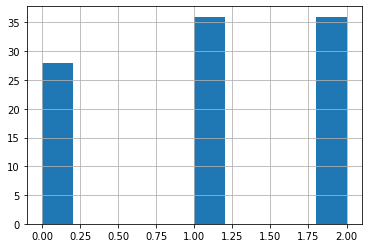

In [16]:
neg_df.label.hist()

In [7]:
dataset['train'][10000:10200]

{'premise': ['A person on a horse jumps over a broken down airplane.',
  'A person on a horse jumps over a broken down airplane.',
  'A person on a horse jumps over a broken down airplane.',
  'Children smiling and waving at camera',
  'Children smiling and waving at camera',
  'Children smiling and waving at camera',
  'A boy is jumping on skateboard in the middle of a red bridge.',
  'A boy is jumping on skateboard in the middle of a red bridge.',
  'A boy is jumping on skateboard in the middle of a red bridge.',
  'An older man sits with his orange juice at a small table in a coffee shop while employees in bright colored shirts smile in the background.',
  'An older man sits with his orange juice at a small table in a coffee shop while employees in bright colored shirts smile in the background.',
  'An older man sits with his orange juice at a small table in a coffee shop while employees in bright colored shirts smile in the background.',
  'Two blond women are hugging one another.'

In [181]:
# NEG = r"""(?:\b(?:no|not|without|nil|never|none|neith|nor|non)\b)|n't"""
NEG = r"""(?:\b(?:no|not)\b)|n't"""

r = re.compile(NEG, flags=re.I | re.X)
eval_df['premise_neg_count'] =  eval_df['premise'].apply(lambda x: len(r.findall(x)))
eval_df['hyp_neg_count'] =  eval_df['hypothesis'].apply(lambda x: len(r.findall(x)))
neg_hyp = eval_df.loc[eval_df.hyp_neg_count > 0]

In [185]:
eval_df.loc[eval_df.premise == 'People standing in line of a beer and curry line.']

,premise,hypothesis,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,logit_0,logit_1,logit_2,correct,premise_neg_count,hyp_neg_count
176,People standing in line of a beer and curry line.,People standing in line,"[101, 2111, 3061, 1999, 2240, 1997, 1037, 5404...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0.032913,0,2.563461,-0.967239,-2.914764,True,0,0
177,People standing in line of a beer and curry line.,People happily standing in line,"[101, 2111, 3061, 1999, 2240, 1997, 1037, 5404...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.013721,1,-1.249188,3.358750,-2.202741,True,0,0
178,People standing in line of a beer and curry line.,People not standing in line,"[101, 2111, 3061, 1999, 2240, 1997, 1037, 5404...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.005238,2,-2.600061,-1.972643,3.704326,True,0,1


In [184]:
neg_hyp

,premise,hypothesis,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,logit_0,logit_1,logit_2,correct,premise_neg_count,hyp_neg_count
178,People standing in line of a beer and curry line.,People not standing in line,"[101, 2111, 3061, 1999, 2240, 1997, 1037, 5404...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.005238,2,-2.600061,-1.972643,3.704326,True,0,1
280,"Two male police officers on patrol, wearing th...",The officers have shot an unarmed black man an...,"[101, 2048, 3287, 2610, 3738, 2006, 6477, 1010...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.525214,2,-3.139103,1.066642,1.451315,True,0,1
376,A man is sitting in on the side of the street ...,a man does not have brass pots,"[101, 1037, 2158, 2003, 3564, 1999, 2006, 1996...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.014121,2,-3.222080,-1.057600,3.304127,True,0,1
421,A man with a white towel wrapped around the lo...,He doesn't want hair to land on his neck.,"[101, 1037, 2158, 2007, 1037, 2317, 10257, 505...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.345027,1,-1.883126,1.339004,0.350566,True,0,1
578,A man is walking away from tents with the word...,The tents do not have anything written on them.,"[101, 1037, 2158, 2003, 3788, 2185, 2013, 1773...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.097265,2,-1.288052,-0.991806,1.845435,True,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19093,A teenage girl in a crowd of people looking up...,no one saw the rainbow in the sky,"[101, 1037, 9454, 2611, 1999, 1037, 4306, 1997...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,4.820199,2,-3.271131,-1.284634,3.526352,False,0,1
19172,A young girl in a pink bikini jumps into the a...,There are no children present.,"[101, 1037, 2402, 2611, 1999, 1037, 5061, 2034...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.003890,2,-3.122002,-1.847906,3.946118,True,0,1
19234,A girl sits at a table in front of a plate of ...,There is no food on the plate.,"[101, 1037, 2611, 7719, 2012, 1037, 2795, 1999...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.003338,2,-3.230085,-1.871974,4.057517,True,0,1
19415,Man balding with a mustache and semi beard sta...,The man has no vocal cords.,"[101, 2158, 13852, 2075, 2007, 1037, 28786, 19...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.828750,2,-0.236021,-0.112475,0.265811,True,0,1


In [182]:
neg_premise = eval_df.loc[eval_df.premise_neg_count > 0]

In [172]:
neg_hyp.correct.sum() / neg_hyp.shape[0]

0.865979381443299

In [176]:
neg_premise.correct.sum() / neg_premise.shape[0]

0.8444444444444444

In [183]:
neg_hyp.correct.sum() / neg_hyp.shape[0], neg_premise.correct.sum() / neg_premise.shape[0]

(0.8571428571428571, 0.8235294117647058)

In [180]:
dd = dataset['validation'].to_pandas()

In [178]:
eval_df.loc[eval_df.labels == 2]

,premise,hypothesis,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,logit_0,logit_1,logit_2,correct,premise_neg_count,hyp_neg_count
2,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,"[101, 2048, 2308, 2024, 23581, 2096, 3173, 200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.001990,2,-3.403698,-2.081107,4.373627,True,0,0
5,"Two young children in blue jerseys, one with t...",Two kids in jackets walk to school.,"[101, 2048, 2402, 2336, 1999, 2630, 28772, 101...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.656617,2,-2.897656,1.134209,1.226241,True,0,0
6,A man selling donuts to a customer during a wo...,A woman drinks her coffee in a small cafe.,"[101, 1037, 2158, 4855, 2123, 16446, 2000, 103...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.002018,2,-3.170765,-2.192689,4.331295,True,0,0
10,Two young boys of opposing teams play football...,dog eats out of bowl,"[101, 2048, 2402, 3337, 1997, 10078, 2780, 237...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.002782,2,-2.993377,-2.111204,4.118332,True,0,0
14,A man in a blue shirt standing in front of a g...,A man is wearing a black shirt,"[101, 1037, 2158, 1999, 1037, 2630, 3797, 3061...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.002525,2,-3.310843,-1.994982,4.223023,True,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19652,A boy drags his sled through the snow.,a boy drags his dog,"[101, 1037, 2879, 8011, 2015, 2010, 22889, 209...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.071691,2,-0.989896,-1.505382,2.077693,True,0,0
19655,A man wearing glasses and a ragged costume is ...,Two men are playing frisbee in the park.,"[101, 1037, 2158, 4147, 7877, 1998, 1037, 1420...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.003797,2,-3.818498,-1.512070,4.154389,True,0,0
19658,A female dancer wearing all white dancing whil...,Some players are playing cricket in ground,"[101, 1037, 2931, 8033, 4147, 2035, 2317, 5613...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.001883,2,-3.156940,-2.257585,4.357893,True,0,0
19661,Two women are observing something together.,Two women are standing with their eyes closed.,"[101, 2048, 2308, 2024, 14158, 2242, 2362, 101...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.097676,2,-1.302323,-0.978671,1.842552,True,0,0


In [167]:
r.findall(eval_df.iloc[18573].premise[:-1] + ' not')

["n't", 'not']

In [162]:
k = pat.match(s)
k

In [158]:
s ='i not a'

In [164]:
r.findall(s)

['not']

In [ ]:
re.compile(r'\bAND\b | \bOR\b | \bNOT\b', flags=re.I | re.X)

In [137]:
eval_df.iloc[18573].premise[:-1] + ' not'

"A young Asian child stands at the top of some steps and does n't seem to notice the person taking their picture not"

In [138]:
NEG_RE.search(eval_df.iloc[18573].premise[:-1] + ' not')

In [131]:
for word in eval_df.iloc[18573].premise:
    print(word)

A
 
y
o
u
n
g
 
A
s
i
a
n
 
c
h
i
l
d
 
s
t
a
n
d
s
 
a
t
 
t
h
e
 
t
o
p
 
o
f
 
s
o
m
e
 
s
t
e
p
s
 
a
n
d
 
d
o
e
s
 
n
'
t
 
s
e
e
m
 
t
o
 
n
o
t
i
c
e
 
t
h
e
 
p
e
r
s
o
n
 
t
a
k
i
n
g
 
t
h
e
i
r
 
p
i
c
t
u
r
e
.


In [124]:
tokenizer.convert_tokens_to_ids('no')

2053

In [125]:
o = tokenizer(eval_df.iloc[18573].premise)

In [129]:
tokenizer.convert_ids_to_tokens(o['input_ids'])

['[CLS]',
 'a',
 'young',
 'asian',
 'child',
 'stands',
 'at',
 'the',
 'top',
 'of',
 'some',
 'steps',
 'and',
 'does',
 'n',
 "'",
 't',
 'seem',
 'to',
 'notice',
 'the',
 'person',
 'taking',
 'their',
 'picture',
 '.',
 '[SEP]']

In [122]:
get_count(eval_df.iloc[18573].premise)

0

In [121]:
eval_df.iloc[18573].premise

"A young Asian child stands at the top of some steps and does n't seem to notice the person taking their picture."

In [118]:
eval_df['premise_neg_count'] =  eval_df['premise'].apply(lambda x: get_count(x))
eval_df['hyp_neg_count'] =  eval_df['hypothesis'].apply(lambda x: get_count(x))
eval_df.loc[eval_df.hyp_neg_count > 0]

In [119]:
eval_df.loc[eval_df.hyp_neg_count > 0]

,premise,hypothesis,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,logit_0,logit_1,logit_2,correct,premise_neg_count,hyp_neg_count


In [116]:
eval_df

,premise,hypothesis,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,logit_0,logit_1,logit_2,correct,premise_neg_count,hyp_neg_count
0,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,"[101, 2048, 2308, 2024, 23581, 2096, 3173, 200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.008911,1,-1.701562,3.582637,-1.969213,True,0,0
1,Two women are embracing while holding to go pa...,Two woman are holding packages.,"[101, 2048, 2308, 2024, 23581, 2096, 3173, 200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0.039708,0,2.316156,-1.212342,-2.179459,True,0,0
2,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,"[101, 2048, 2308, 2024, 23581, 2096, 3173, 200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.001990,2,-3.403698,-2.081107,4.373627,True,0,0
3,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.,"[101, 2048, 2402, 2336, 1999, 2630, 28772, 101...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0.028206,0,2.583757,-1.187957,-2.602218,True,0,0
4,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,"[101, 2048, 2402, 2336, 1999, 2630, 28772, 101...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.051390,1,-2.916604,2.854484,-0.148932,True,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19661,Two women are observing something together.,Two women are standing with their eyes closed.,"[101, 2048, 2308, 2024, 14158, 2242, 2362, 101...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.097676,2,-1.302323,-0.978671,1.842552,True,0,0
19662,Two women are observing something together.,Two girls are looking at something.,"[101, 2048, 2308, 2024, 14158, 2242, 2362, 101...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0.092393,0,2.142035,-0.260276,-2.927275,True,0,0
19663,A man in a black leather jacket and a book in ...,A man is flying a kite.,"[101, 1037, 2158, 1999, 1037, 2304, 5898, 6598...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.002443,2,-3.890090,-1.725126,4.397014,True,0,0
19664,A man in a black leather jacket and a book in ...,A man is speaking in a classroom.,"[101, 1037, 2158, 1999, 1037, 2304, 5898, 6598...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0.018493,0,2.995694,-1.073183,-3.462047,True,0,0


In [111]:
get_count(data.premise)

0

In [106]:
import re
for index, data in eval_df.iterrows():
    count = 0
    for neg in NEGATION_ADVERBS:
        count += len([m.start() for m in re.finditer(neg,data.premise)])
    if count:
        break

In [109]:
data.premise

'A woman is writing something on a post-it note which is hanging on a bulletin board with a lot of other post-it notes.'

In [105]:
index

0

In [95]:
eval_df.premise[0]

'Two women are embracing while holding to go packages.'

In [93]:
negs.isin(eval_df.premise[0])

TypeError: only list-like objects are allowed to be passed to isin(), you passed a [str]

In [89]:
eval_df['p_n_count'] = 

,premise,hypothesis,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,logit_0,logit_1,logit_2,correct
0,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,"[101, 2048, 2308, 2024, 23581, 2096, 3173, 200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.008911,1,-1.701562,3.582637,-1.969213,True
1,Two women are embracing while holding to go pa...,Two woman are holding packages.,"[101, 2048, 2308, 2024, 23581, 2096, 3173, 200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0.039708,0,2.316156,-1.212342,-2.179459,True
2,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,"[101, 2048, 2308, 2024, 23581, 2096, 3173, 200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.001990,2,-3.403698,-2.081107,4.373627,True
3,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.,"[101, 2048, 2402, 2336, 1999, 2630, 28772, 101...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0.028206,0,2.583757,-1.187957,-2.602218,True
4,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,"[101, 2048, 2402, 2336, 1999, 2630, 28772, 101...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.051390,1,-2.916604,2.854484,-0.148932,True
...,...,...,...,...,...,...,...,...,...,...,...,...
19661,Two women are observing something together.,Two women are standing with their eyes closed.,"[101, 2048, 2308, 2024, 14158, 2242, 2362, 101...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.097676,2,-1.302323,-0.978671,1.842552,True
19662,Two women are observing something together.,Two girls are looking at something.,"[101, 2048, 2308, 2024, 14158, 2242, 2362, 101...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0.092393,0,2.142035,-0.260276,-2.927275,True
19663,A man in a black leather jacket and a book in ...,A man is flying a kite.,"[101, 1037, 2158, 1999, 1037, 2304, 5898, 6598...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.002443,2,-3.890090,-1.725126,4.397014,True
19664,A man in a black leather jacket and a book in ...,A man is speaking in a classroom.,"[101, 1037, 2158, 1999, 1037, 2304, 5898, 6598...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,0.018493,0,2.995694,-1.073183,-3.462047,True


In [68]:
errors.iloc[2283 - int(2283/3)]

premise            A black and white bird with a yellow beak is f...
hypothesis                       Bird flying outside against the sky
input_ids          [101, 1037, 2304, 1998, 2317, 4743, 2007, 1037...
token_type_ids     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
attention_mask     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
labels                                                             1
loss                                                        1.232632
predicted_label                                                    0
logit_0                                                     1.543063
logit_1                                                     0.666259
logit_2                                                    -2.944212
Name: 14145, dtype: object

In [ ]:
tokens, attentions, b_start = get_attention(eval_dataset_featurized, 6208)

In [ ]:
model_view(attentions, tokens, b_start)

In [ ]:
head_view(attentions, tokens, b_start)

In [16]:
errors = eval_df.loc[eval_df.labels != eval_df.predicted_label].sort_values('loss', ascending=False)
errors

,premise,hypothesis,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,logit_0,logit_1,logit_2
1708,,The little girl is planting her first flower.,"[101, 102, 1996, 2210, 2611, 2003, 14685, 2014...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",0,4.945373,1,-2.366696,2.458108,0.338765
6158,,a dog sitting on a bed after ripping up paper.,"[101, 102, 1037, 3899, 3564, 2006, 1037, 2793,...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",0,4.860991,2,-2.651875,0.794354,1.920466
175,,The people are having a food fight.,"[101, 102, 1996, 2111, 2024, 2383, 1037, 2833,...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",0,4.819573,2,-2.373949,-0.043840,2.350188
4148,,There are only families at the beach today.,"[101, 102, 2045, 2024, 2069, 2945, 2012, 1996,...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",0,4.765400,2,-2.056419,-0.745985,2.668046
5405,,There are no females around them.,"[101, 102, 2045, 2024, 2053, 3801, 2105, 2068,...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...",1,4.751141,2,-1.656139,-1.632969,3.100938
...,...,...,...,...,...,...,...,...,...,...,...
1641,,The two people run as quickly as they can for ...,"[101, 102, 1996, 2048, 2111, 2448, 2004, 2855,...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.725753,1,-2.539442,1.392833,1.348060
523,,A homeless man has stolen a child's violin in ...,"[101, 102, 1037, 11573, 2158, 2038, 7376, 1037...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,0.723321,1,-2.859130,1.585829,1.538035
5642,,These three cyclists are bitter rivals.,"[101, 102, 2122, 2093, 21912, 2024, 8618, 9169...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...",1,0.717352,2,-2.834848,1.521906,1.557448
3322,,"A girl is crying, because she skinned her knee.","[101, 102, 1037, 2611, 2003, 6933, 1010, 2138,...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",1,0.714231,2,-2.365156,1.276089,1.292351


In [19]:
eval_df.loc[eval_df.hypothesis == 'The sisters are hugging goodbye while holding to go packages after just eating lunch.']

,premise,hypothesis,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,logit_0,logit_1,logit_2
0,,The sisters are hugging goodbye while holding ...,"[101, 102, 1996, 5208, 2024, 17662, 9119, 2096...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,0.0865,1,-2.388975,2.648684,0.170106


In [ ]:
errors.iloc[:]

In [ ]:
eval_df.sort_values('loss', ascending=False)

In [ ]:
accuracy = (eval_df.labels == eval_df.predicted_label).sum() / eval_df.shape[0]
accuracy

In [ ]:
type(sample['labels'])

In [ ]:
sample['labels']

In [ ]:
torch.Tensor(sample['labels'])

In [ ]:
# loss = nn.CrossEntropyLoss()
model_keys = ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
# model.to(device)
eval_samples = []
for n, sample in tqdm(enumerate(eval_dataset_featurized), total=len(eval_dataset_featurized)):

    # Change labels depending on whether you're doing NER/Parsing (token classification)
    # or sentiment classification (sequence classification)
    # ELECTRA Page linked here: https://huggingface.co/transformers/model_doc/electra.html
    model_inputs = {k:torch.LongTensor(v).reshape(1,-1) for k,v in sample.items() if k in model_keys}
    model_output = model(**model_inputs)
    sample['loss'] = model_output.loss.item()
    
    eval_samples.append()


In [ ]:
sample

In [ ]:
model_output.loss.item()

In [ ]:
labels

In [ ]:
batch['input_ids']